# Amazon Web Scraping

## Yinghong Xu

In [1]:
from bs4 import BeautifulSoup as soup
from urllib.request import urlopen as uReq
import pandas as pd
import numpy as np

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

from sklearn.model_selection import train_test_split

In [90]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [88]:
# my_url='https://www.amazon.com/Best-Sellers-Sports-Outdoors/zgbs/sporting-goods/ref=zg_bs_pg_1?_encoding=UTF8&pg=1'

# Scrape Data from Amazon
products={}
prd_no=0

urls=[]
for page in range(3):
    urls.append('https://www.amazon.com/Best-Sellers-Sports-Outdoors/zgbs/sporting-goods/ref=zg_bs_pg_{}?_encoding=UTF8&pg={}'.format(page, page))
page=urls[1:]

for p in page:
    uClient=uReq(p)
    page_html=uClient.read()
    uClient.close()
    page_soup=soup(page_html, "html.parser")
    containers= page_soup.findAll("div",{"class":"a-section a-spacing-none aok-relative"})
         
    for container in containers:
        #product_name=container.div.img["alt"].replace("," , "|")
        
        product_name=container.findAll("div", {"class": "a-section a-spacing-small"})[0].img["alt"]
        link_container=container.findAll("a", {"class":"a-link-normal"})[0]["href"]
        preflix="https://www.amazon.com"
        link=preflix+link_container
        
        #price
        if container.findAll("span", {"class":"p13n-sc-price"}):
            price=container.findAll("span", {"class":"p13n-sc-price"})[0].text
        else:
            price=""  
        #rating
        if container.findAll("span", {"class":"a-icon-alt"}):
            rating=container.findAll("span", {"class":"a-icon-alt"})[0].text
        else:
            rating=""
        #reviews
        if container.findAll("a", {"class":"a-size-small a-link-normal"}):
            reviews=container.findAll("a", {"class":"a-size-small a-link-normal"})[0].text
        else:
            reviews=""    
        #rank
        rank=container.findAll("span", {"class":"zg-badge-text"})[0].text
        
        prd_no+=1
        products[prd_no]=[product_name, rank, link, price, rating, reviews]
#         print("Product name: "+product_name)
#         print("Product link: "+ link)
#         print("price: "+ price)
#         print("Rating: "+rating)
#         print("Reviews:"+reviews)
   
print(products[1])


['Letsfit Resistance Loop Bands, Resistance Exercise Bands for Home Fitness, Stretching, Strength Training, Physical Therapy, Natural Latex Workout Bands, Pilates Flexbands, 12" x 2"', '#1', 'https://www.amazon.com/Letsfit-Resistance-Exercise-Stretching-Strength/dp/B07CZYTLQN?_encoding=UTF8&psc=1', '$16.99', '4.4 out of 5 stars', '8,370']


In [4]:
prd_no

100

In [5]:
products_df=pd.DataFrame.from_dict(products, orient='index', columns=['product_name', 'rank', 'link', 'price', 'rating', 'reviews'])
products_df.head()

,product_name,rank,link,price,rating,reviews
1,"Letsfit Resistance Loop Bands, Resistance Exer...",#1,https://www.amazon.com/Letsfit-Resistance-Exer...,$16.99,4.4 out of 5 stars,"8,298"
2,Hanes Women's Jersey Short,#2,https://www.amazon.com/Hanes-Womens-Jersey-Sho...,$6.96,4.4 out of 5 stars,"3,155"
3,Fit Simplify Resistance Loop Exercise Bands wi...,#3,https://www.amazon.com/Fit-Simplify-Resistance...,$17.85,4.3 out of 5 stars,"17,747"
4,OUYZY Face Scarf Cover Mask - Sun Dust Bandana...,#4,https://www.amazon.com/OUYZY-Balaclava-Motorcy...,$9.99,4.4 out of 5 stars,664
5,YiwsKbo Fingertip Oximeter Blood Measure Oxyge...,#5,https://www.amazon.com/YiwsKbo-Fingertip-Satur...,$36.99,5.0 out of 5 stars,2


In [6]:
products_df.to_csv('prds.csv', index=False)

In [7]:
import findspark
findspark.init()

In [8]:
from pyspark.sql import SparkSession
ss = SparkSession.builder.master("local") .appName("Word Count") .getOrCreate()

In [9]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

In [11]:
df=pd.read_csv('prds.csv')

In [12]:
# Clean data

df['rank']=df['rank'].str.strip('#')
df.price=df.price.str.strip('$')

tdf=df.rating.str.split(' ', expand=True)[0]
df.rating=tdf

tdf=df.link.str.split('/', expand=True)[3]
df['name']=tdf

#df.head()

df1=df.drop('link', axis=1)


df1['name']=df1['name'].str.lower().str.replace('-',' ')
df1['name']=df1['name'].str.replace('%',' ')

# sdf=ss.createDataFrame(df[['']])
# sdf.head()

# df1.to_csv('df1.csv')
df1.head()

,product_name,rank,price,rating,reviews,name
0,"Letsfit Resistance Loop Bands, Resistance Exer...",1,16.99,4.4,"8,298",letsfit resistance exercise stretching strength
1,Hanes Women's Jersey Short,2,6.96,4.4,"3,155",hanes womens jersey short black
2,Fit Simplify Resistance Loop Exercise Bands wi...,3,17.85,4.3,"17,747",fit simplify resistance exercise instruction
3,OUYZY Face Scarf Cover Mask - Sun Dust Bandana...,4,9.99,4.4,664,ouyzy balaclava motorcycling skateboarding pro...
4,YiwsKbo Fingertip Oximeter Blood Measure Oxyge...,5,36.99,5.0,2,yiwskbo fingertip saturation plethysmograph pe...


In [13]:
sdf=ss.createDataFrame(df1[['rank','name']])
sdf.head()

Row(rank='1', name='letsfit resistance exercise stretching strength')

In [14]:
tokenizer = Tokenizer(inputCol="name", outputCol="words")
vectorizer = CountVectorizer(inputCol="words", outputCol="rawFeatures")

In [16]:
pipeline = Pipeline(stages=[tokenizer, vectorizer])
model = pipeline.fit(sdf)

In [17]:
t_vectors = model.transform(sdf)
t_vectors.show(5)

+----+--------------------+--------------------+--------------------+
|rank|                name|               words|         rawFeatures|
+----+--------------------+--------------------+--------------------+
|   1|letsfit resistanc...|[letsfit, resista...|(360,[0,4,60,228,...|
|   2|hanes womens jers...|[hanes, womens, j...|(360,[1,2,3,10,25...|
|   3|fit simplify resi...|[fit, simplify, r...|(360,[0,4,71,136,...|
|   4|ouyzy balaclava m...|[ouyzy, balaclava...|(360,[7,234,254,3...|
|   5|yiwskbo fingertip...|[yiwskbo, fingert...|(360,[55,70,87,14...|
+----+--------------------+--------------------+--------------------+
only showing top 5 rows



In [18]:
sparce_vectors=t_vectors.select('rawFeatures').rdd\
.map(lambda row: row['rawFeatures'].toArray()) #\
sparce_vectors.take(1)[0].shape

(360,)

In [19]:
total_counts=sparce_vectors.reduce(lambda x,y: [x[i]+y[i] for i in range(len(y))])
vocabList = model.stages[1].vocabulary
d = {'vocabList':vocabList,'counts':total_counts}

In [135]:
# Pyspark word counts

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

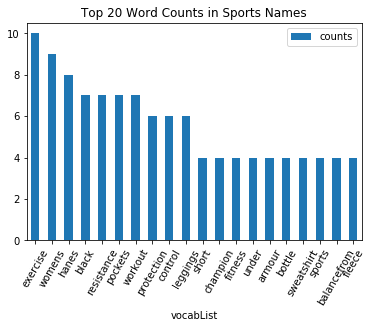

In [20]:
ddf=pd.DataFrame(d).set_index('vocabList') 
# my_colors = 'rgbkymc'
ddf.head(20).plot(kind='bar')
plt.title("Top 20 Word Counts in Sports Names")
plt.xticks(rotation=60)

In [22]:
from wordcloud import WordCloud

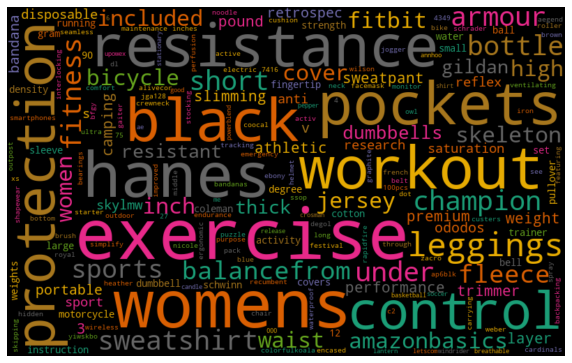

In [33]:
wordcloudConvertDF = ddf.T.to_dict('records')
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2')\
.generate_from_frequencies(dict(*wordcloudConvertDF))
plt.figure(figsize=(10, 8))    
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [34]:
#clean data
df_new=df1.dropna(axis='rows')

df_new.reviews=df_new.reviews.str.replace(',', '')
df_new['reviews'] = df_new['reviews'].astype(int)
df_new['price'] = pd.to_numeric(df_new['price'])
df_new['rank'] = pd.to_numeric(df_new['rank'])
df_new['rating'] = pd.to_numeric(df_new['rating'])

D:\Anaconda\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ver

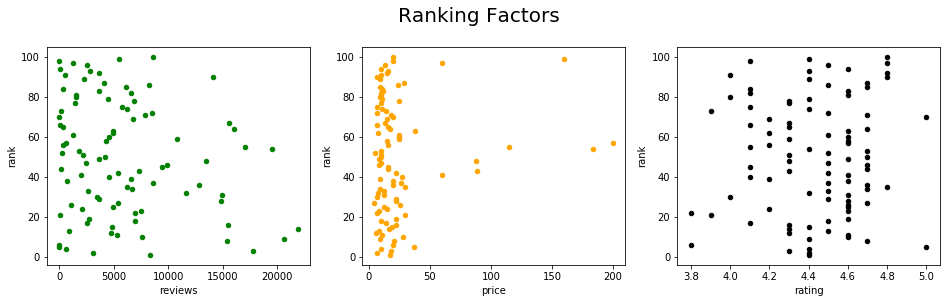

In [35]:
#plt.figure(figsize=(16, 8))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))
fig.suptitle('Ranking Factors', size=20, y=1.02)

df_new.plot(x='price', y='rank', kind='scatter', color='orange', ax=ax2)
df_new.plot(x='reviews', y='rank', kind='scatter', color='green', ax=ax1)
df_new.plot(x='rating',y='rank', kind='scatter', color='black', ax=ax3)

In [36]:
X = df_new[['rating', 'price','reviews']]
y = df_new['rank']
# reg = LinearRegression()
# reg.fit(X, y)
# reg.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 1)

print('Training Data Count: {}'.format(X_train.shape[0]))
print('Testing Data Count: {}'.format(X_test.shape[0]))

Training Data Count: 84
Testing Data Count: 10


In [37]:
X_train = sm.add_constant(X_train)
results = sm.OLS(y_train, X_train).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   rank   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     1.895
Date:                Sun, 26 Apr 2020   Prob (F-statistic):              0.137
Time:                        00:36:46   Log-Likelihood:                -398.73
No. Observations:                  84   AIC:                             805.5
Df Residuals:                      80   BIC:                             815.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         43.8086     52.682      0.832      0.4

D:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
